# **PRA UAS Penambangan Data**

# **1. Dataset**

📌 Sumber Dataset
Dataset diambil dari UCI Machine Learning Repository:
Judul: Product Classification and Clustering

🔗 https://archive.ics.uci.edu/dataset/837/product%2Bclassification%2Band%2Bclustering?

Dataset ini berisi informasi mengenai lebih dari 35.000 produk yang diklasifikasikan berdasarkan judul, kategori, dan merchant.

- Apa itu?
Dataset adalah sekumpulan data yang digunakan sebagai bahan utama untuk dianalisis dalam proyek penambangan data.

- Penjelasan:
Pada proyek ini, dataset yang digunakan berjudul Product Classification and Clustering, diambil dari UCI Machine Learning Repository. Dataset ini berisi informasi tentang lebih dari 35.000 produk yang dikumpulkan dari situs PriceRunner, termasuk:

 Judul produk (Product Title)

 ID penjual (Merchant ID)

 Kategori produk (Category Label)

 Cluster alami berdasarkan kemiripan judul (Cluster Label)

- Tujuan:
Dataset ini digunakan untuk membangun sistem yang mampu:

 Mengelompokkan produk berdasarkan kemiripan judul (clustering)

 Memprediksi kategori produk dari judul (klasifikasi)

# **2. Data Understanding**

Apa itu? Data Understanding adalah tahap awal dalam proses data mining yang bertujuan untuk memahami struktur, isi, dan kualitas data.

## **a. Penjelasan Fitur**

product_title adalah fitur utama karena berbentuk teks dan akan digunakan sebagai dasar klasifikasi & clustering.

category_label adalah target klasifikasi.

cluster_label dapat digunakan sebagai pembanding pada clustering.

In [ ]:
fitur_deskripsi = {
    "product_id": "ID unik dari produk",
    "product_title": "Judul teks dari produk",
    "merchant_id": "ID unik dari penjual",
    "cluster_id": "Cluster alami dari produk (berdasarkan kemiripan judul)",
    "cluster_label": "Label nama cluster alami",
    "category_id": "ID numerik dari kategori produk",
    "category_label": "Nama kategori produk"
}


## **b. Eksplorasi**

Tujuan eksplorasi ini:

Memastikan data bersih (tanpa NaN)

Mengetahui persebaran kategori

Menambahkan informasi baru (title_length) sebagai fitur numerik tambahan


In [ ]:
from google.colab import files

# Unggah file dari lokal
uploaded = files.upload()

import pandas as pd

df = pd.read_csv('pricerunner_aggregate.csv')

# Hapus spasi di awal/akhir nama kolom
df.columns = df.columns.str.strip()

# Cek missing values
print(df.isnull().sum())

# Distribusi kategori
print(df['Category Label'].value_counts())

# Tambah kolom panjang judul
df['title_length'] = df['Product Title'].str.split().apply(len)
print(df['title_length'].describe())

Saving pricerunner_aggregate.csv to pricerunner_aggregate (1).csv
Product ID        0
Product Title     0
Merchant ID       0
Cluster ID        0
Cluster Label     0
Category ID       0
Category Label    0
dtype: int64
Category Label
Fridge Freezers     5501
Mobile Phones       4081
Washing Machines    4044
CPUs                3862
Fridges             3584
TVs                 3564
Dishwashers         3424
Digital Cameras     2697
Microwaves          2342
Freezers            2212
Name: count, dtype: int64
count    35311.000000
mean         8.665911
std          4.166677
min          1.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         37.000000
Name: title_length, dtype: float64


## **c. Visualisasi**

Visualisasi digunakan untuk memahami struktur distribusi data secara visual:

Apakah beberapa kategori mendominasi?

Apakah judul produk umumnya panjang atau pendek?

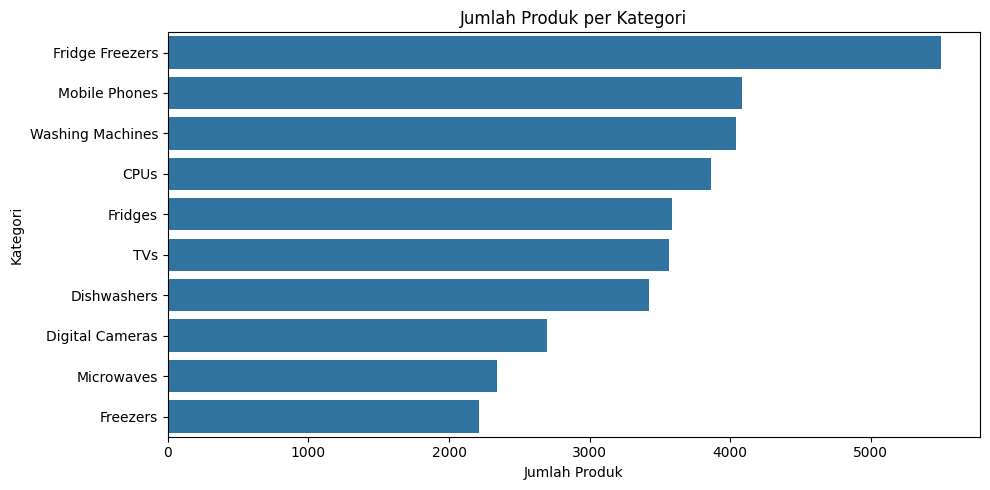

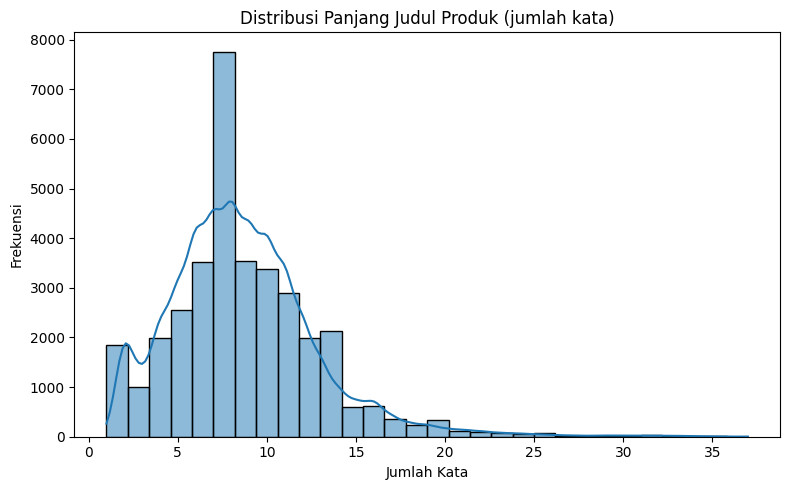

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan kolom tidak mengandung spasi di awal/akhir
df.columns = df.columns.str.strip()

# Ganti 'category_label' menjadi 'Category Label' dan set kolomnya agar cocok
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='Category Label', order=df['Category Label'].value_counts().index)
plt.title('Jumlah Produk per Kategori')
plt.xlabel('Jumlah Produk')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

# Panjang judul produk (pastikan sebelumnya sudah dibuat kolom title_length)
plt.figure(figsize=(8, 5))
sns.histplot(df['title_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Judul Produk (jumlah kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# **3. Preprocessing**

Apa itu? Preprocessing adalah tahap pengolahan data mentah agar dapat digunakan oleh algoritma machine learning.

- Yang dilakukan:

  TF-IDF Vectorization: Mengubah teks (judul produk) menjadi angka agar bisa diproses oleh komputer

  Stopwords Removal: Menghapus kata-kata umum yang tidak bermakna (seperti "the", "and", "of")

  Reduksi Dimensi (Truncated SVD): Mengurangi jumlah fitur agar komputasi lebih efisien dan bisa divisualisasikan

  Tujuan:
  Menyiapkan data dalam format numerik dan ringkas agar algoritma dapat bekerja dengan lebih baik dan lebih cepat.



## **TF-IDF dan Reduksi Dimensi**

TF-IDF mengubah teks ke bentuk numerik berbobot kata.

Truncated SVD (Latent Semantic Analysis) menurunkan dimensi fitur agar lebih ringan & bisa divisualisasi (misal: scatter plot).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Pastikan kolom tidak ada spasi di awal/akhir
df.columns = df.columns.str.strip()

# Gunakan kolom yang benar untuk judul produk: 'Product Title'
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['Product Title'])  # Kolom dengan huruf besar dan spasi sesuai CSV

# Reduksi dimensi ke 2 dimensi (untuk clustering dan visualisasi)
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# **4. Clustering & Klasifikasi**

Apa itu?
Tahap utama dari proyek di mana dilakukan proses analisis menggunakan algoritma machine learning.

a. Clustering (Unsupervised Learning)
Tujuan: Mengelompokkan produk berdasarkan kemiripan judul, tanpa melihat label kategori

Metode: K-Means

Evaluasi: Silhouette Score → menunjukkan seberapa baik pemisahan antar cluster

b. Klasifikasi (Supervised Learning)
Tujuan: Memprediksi kategori produk berdasarkan teks judul

Metode: Multinomial Naive Bayes

Evaluasi: Classification Report (Precision, Recall, F1-score, Accuracy)

Perbedaan utama:

Clustering tidak membutuhkan label (unsupervised)

Klasifikasi membutuhkan label target (supervised)

## **Clustering (K-Means)**

Mengelompokkan produk berdasarkan kesamaan judul

Mengevaluasi hasil cluster dengan Silhouette Score

Skor > 0.5 → bagus

Skor 0.2–0.5 → cukup baik

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_svd)

sil_score = silhouette_score(X_svd, cluster_labels)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.5089452678654753


## **Klasifikasi (Naive Bayes)**

Hasil akan menunjukkan metrik evaluasi:

Precision: Akurasi positif per kategori

Recall: Kemampuan menangkap seluruh data positif

F1-score: Harmonis antara precision dan recall

Accuracy total

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Pastikan kolom tidak ada spasi di awal/akhir
df.columns = df.columns.str.strip()

# Split data untuk klasifikasi dengan target 'Category Label'
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['Category Label'], test_size=0.3, random_state=42)

# Gunakan Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Tampilkan hasil evaluasi
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00      1139
 Digital Cameras       0.98      0.99      0.99       826
     Dishwashers       0.85      0.95      0.90      1000
        Freezers       0.96      0.55      0.70       652
 Fridge Freezers       0.77      0.89      0.82      1676
         Fridges       0.82      0.78      0.80      1102
      Microwaves       0.99      0.93      0.96       694
   Mobile Phones       0.99      0.97      0.98      1223
             TVs       0.96      0.97      0.97      1090
Washing Machines       0.94      0.93      0.94      1192

        accuracy                           0.91     10594
       macro avg       0.93      0.90      0.90     10594
    weighted avg       0.91      0.91      0.91     10594



# **5. Evaluasi Model**
Clustering: menggunakan Silhouette Score

Klasifikasi: akurasi, precision, recall, F1 (sudah ditampilkan lewat classification_report)

Apa itu?
Evaluasi model adalah proses untuk mengukur seberapa baik model yang kita buat dalam menjalankan tugasnya.

Metode Evaluasi:

Clustering: menggunakan Silhouette Score
Nilai mendekati 1 artinya cluster sangat baik

Klasifikasi: menggunakan Classification Report
Meliputi akurasi, precision, recall, dan F1-score

Tujuan:
Menentukan apakah model yang dibangun sudah layak untuk digunakan atau perlu ditingkatkan.